In [1]:
import uproot
import awkward
import numpy
import matplotlib.pyplot as plt
import matplotlib.figure as figure
import keras
import keras.layers as layers
from Sum import Sum
from sklearn.model_selection import train_test_split
import pandas as pd
from numpy.lib.recfunctions import structured_to_unstructured
from tensorflow.keras import callbacks
import tensorflow as tf
import time

2023-01-14 09:48:32.482933: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-14 09:48:32.640575: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-14 09:48:32.644636: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-14 09:48:32.644652: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
#Set hyperparameters
MASKVAL = -999
MAXTRACKS = 32
BATCHSIZE = 64
EPOCHS = 175
MAXEVENTS = 99999999999999999
# VALFACTOR = 10
LR = 1e-2

In [3]:
# Define Callbacks

# Define Early Stopping
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,
    patience = 50,
    restore_best_weights = True,
)

#Save weights throughout
#save_weights = callbacks.ModelCheckpoint('/home/physics/phuspv/.ssh/Project/Weights/Inbox.ckpt', save_weights_only=True, monitor='loss', mode='min', save_best_only=True)

#Define ReducedLR
reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.9, patience=5, min_lr=1e-99)
        
#Define timehistory class to track average epoch times
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

#Open the root file
tree = uproot.open("hffrag.root:CharmAnalysis")


# In[55]:


# Decide which branches of the tree we actually want to look at
# Not currently used!
branches = \
  [ \

  # true jet information
   "AnalysisAntiKt4TruthJets_pt", "AnalysisAntiKt4TruthJets_eta", "AnalysisAntiKt4TruthJets_phi", "AnalysisAntiKt4TruthJets_m"

  # true b-hadron information
  # these b-hadrons are inside the truth jets
   ,"AnalysisAntiKt4TruthJets_ghostB_pdgId", "AnalysisAntiKt4TruthJets_ghostB_pt", "AnalysisAntiKt4TruthJets_ghostB_eta", "AnalysisAntiKt4TruthJets_ghostB_phi", "AnalysisAntiKt4TruthJets_ghostB_m"
  

  # reconstructed jet information
   , "AnalysisJets_pt_NOSYS", "AnalysisJets_eta", "AnalysisJets_phi", "AnalysisJets_m"
 
  # reconstructed track information
  , "AnalysisTracks_pt", "AnalysisTracks_eta", "AnalysisTracks_phi", "AnalysisTracks_z0sinTheta", "AnalysisTracks_d0sig", "AnalysisTracks_d0", "AnalysisTracks_d0sigPV", "AnalysisTracks_d0PV"
  ]


  # True jet information
jetfeatures = \
  [ "AnalysisAntiKt4TruthJets_pt", "AnalysisAntiKt4TruthJets_eta", "AnalysisAntiKt4TruthJets_phi", "AnalysisAntiKt4TruthJets_ghostB_pt", "AnalysisAntiKt4TruthJets_ghostB_eta", "AnalysisAntiKt4TruthJets_ghostB_phi"]

# true b-hadron information
# these b-hadrons are inside the truth jets
bhadfeatures = \
   [ "AnalysisAntiKt4TruthJets_ghostB_pt", "AnalysisAntiKt4TruthJets_ghostB_eta", "AnalysisAntiKt4TruthJets_ghostB_phi", "AnalysisAntiKt4TruthJets_ghostB_m"]
  

# reconstructed track information
trackfeatures = \
  [ "AnalysisTracks_pt", "AnalysisTracks_eta", "AnalysisTracks_phi", "AnalysisTracks_z0sinTheta", "AnalysisTracks_d0sig", "AnalysisTracks_d0", "AnalysisTracks_d0sigPV", "AnalysisTracks_d0PV"]
features = tree.arrays(jetfeatures + trackfeatures + branches, entry_stop=MAXEVENTS)


In [15]:
#Find where angular distance is small
def matchTracks(jets, trks):
  jeteta = jets["AnalysisAntiKt4TruthJets_eta"] 
  jetphi = jets["AnalysisAntiKt4TruthJets_phi"]

  trketas = trks["AnalysisTracks_eta"]
  trkphis = trks["AnalysisTracks_phi"]

  detas = jeteta - trketas
  dphis = numpy.abs(jetphi - trkphis)

  # deal with delta phis being annoying
  awkward.where(dphis > numpy.pi, dphis - numpy.pi, dphis)

  return numpy.sqrt(dphis**2 + detas**2) < 0.4

  
#Converting from polar to cartesian

#Used for jets
def ptetaphi2pxpypz(ptetaphi):
  pts = ptetaphi[:,0:1]
  etas = ptetaphi[:,1:2]
  phis = ptetaphi[:,2:3]

  pxs = pts * numpy.cos(phis)
  pys = pts * numpy.sin(phis)
  pzs = pts * numpy.sinh(etas)

  isinf = numpy.isinf(pzs)

  if numpy.any(isinf):
    print("inf from eta:")
    print(etas[isinf])
    raise ValueError("infinity from sinh(eta)")

  return numpy.concatenate([pxs, pys, pzs], axis=1)

#Used for tracks
def ptetaphi2pxpypz2(ptetaphi):
  pts = ptetaphi[:,:,0:1]
  etas = ptetaphi[:,:,1:2]
  phis = ptetaphi[:,:,2:3]

  mask = pts == MASKVAL
  #Looking in array and testing a condition - if finds mask, replaces mask with pt value
  pxs = numpy.where(mask, pts, pts * numpy.cos(phis)) # Apply transformation only to actual pT
  pys = numpy.where(mask, pts, pts * numpy.sin(phis))
  pzs = numpy.where(mask, pts, pts * numpy.sinh(etas))

  isinf = numpy.isinf(pzs)

  if numpy.any(isinf):
    print("inf from eta:")
    print(etas[isinf])
    raise ValueError("infinity from sinh(eta)")

  return numpy.concatenate([pxs, pys, pzs], axis=2)

# Pads inputs with nans up to the given maxsize
def pad(xs, maxsize):
  #Find 'none' values in array and replace with MASKVAL (= fill_none)
  ys = \
    awkward.fill_none \
  ( awkward.pad_none(xs, maxsize, axis=1, clip=True) #Adding 'none' values to make sure it is correct size
  , MASKVAL
  )[:,:maxsize]

  return awkward.to_regular(ys, axis=1)

def flatten1(xs, maxsize=-1):
  ys = {}
  for field in xs.fields:
    zs = xs[field]
    if maxsize > 0:
      zs = pad(zs, maxsize)
    ys[field] = zs

  return awkward.zip(ys)

#Define histogram plotting functions
# returns a fixed set of bin edges
def fixedbinning(xmin, xmax, nbins):
  return numpy.mgrid[xmin:xmax:nbins*1j]


# define two functions to aid in plotting
def hist(xs, binning, normalized=False):
  ys = numpy.histogram(xs, bins=binning)[0]

  yerrs = numpy.sqrt(ys)

  if normalized:
    s = numpy.sum(ys)
    ys = ys / s
    yerrs = yerrs / s

  return ys, yerrs


def binneddensity(xs, binning, label=None, xlabel=None, ylabel="binned probability density"):
  fig = figure.Figure(figsize=(8, 8))
  plt = fig.add_subplot(111)

  ys , yerrs = hist(xs, binning, normalized=True)

  # determine the central value of each histogram bin
  # as well as the width of each bin
  # this assumes a fixed bin size.
  xs = (binning[1:]+binning[:-1]) / 2.0
  xerrs = ((binning[1:]-binning[:-1]) / 2.0)

  plt.errorbar \
    ( xs
    , ys
    , xerr=xerrs
    , yerr=yerrs
    , label=label
    , linewidth=0
    , elinewidth=2
    )

  plt.set_xlabel(xlabel)
  plt.set_ylabel(ylabel)

  return fig

events = \
features[awkward.sum(features["AnalysisAntiKt4TruthJets_pt"] > 25000, axis=1) > 0]

jets1 = events[jetfeatures][:,0] #First jet
tracks = events[trackfeatures]

matchedtracks = tracks[matchTracks(jets1, tracks)] 
matchedtracks = flatten1(matchedtracks, MAXTRACKS) #Turn into regular np array

bjets = awkward.sum(jets1["AnalysisAntiKt4TruthJets_ghostB_pt"] > 5000, axis=1) > 0 #Find b hadron jets with certain momentum
jets2 = jets1[bjets] #Jets identified as b jets are only jets considered
bhadspt= jets2["AnalysisAntiKt4TruthJets_ghostB_pt"][:,0] #np Stack here - Each sub array contains all the features of the jet (axis -1)
bhadseta = jets2["AnalysisAntiKt4TruthJets_ghostB_eta"][:, 0]
bhadsphi = jets2["AnalysisAntiKt4TruthJets_ghostB_phi"][:,0]
matchedtracks = matchedtracks[bjets]


jets3 = structured_to_unstructured(jets2[jetfeatures[:-3]]) #number of features
matchedtracks = structured_to_unstructured(matchedtracks)
jets4 = ptetaphi2pxpypz(jets3).to_numpy()
tracks = ptetaphi2pxpypz2(matchedtracks.to_numpy())
tracks = numpy.concatenate([tracks, matchedtracks[:,:,3:].to_numpy()], axis = 2)

bhadspt = bhadspt.to_numpy()
bhadseta = bhadseta.to_numpy()
bhads = numpy.stack([bhadspt, bhadseta], axis=-1)
bhadMean = numpy.mean(bhads[:,0])
bhadStd = numpy.std(bhads[:,0])
bhadMedian = numpy.median(bhads[:,0])
bhadIQR = numpy.percentile(bhads[:,0], 75)-numpy.percentile(bhads[:,0], 25)


truejetpt = features["AnalysisAntiKt4TruthJets_pt"]
truejeteta = features["AnalysisAntiKt4TruthJets_eta"]
jetpT = jets3[:,0]
jetEta = jets3[:,1]
jetphi = jets3[:,2]
jets5 = numpy.stack([jetpT, jetEta], axis = -1).to_numpy()

tneurons = 32
jneurons = 2* tneurons
tracklayers =  [ tneurons , tneurons , tneurons , tneurons , tneurons ]
jetlayers = [ jneurons , jneurons , jneurons , jneurons , jneurons ]


def buildModel(tlayers, jlayers, ntargets):  
  inputs = layers.Input(shape=(None, tlayers[0]))

  outputs = inputs
  outputs = layers.Masking(mask_value=MASKVAL)(outputs)

  for nodes in tlayers[:-1]:
    outputs = layers.Dropout(0.3)(outputs)
    outputs = layers.TimeDistributed(layers.Dense(nodes, activation='relu'))(outputs)
    outputs = layers.BatchNormalization()(outputs)

  outputs = layers.TimeDistributed(layers.Dense(tlayers[-1], activation='softmax'))(outputs)
  outputs = Sum()(outputs)

  for nodes in jlayers:
    outputs = layers.Dropout(0.3)(outputs)
    outputs = layers.Dense(nodes, activation='relu')(outputs)
    outputs = layers.BatchNormalization()(outputs)

  outputs = layers.Dense(ntargets + ntargets*(ntargets+1)//2)(outputs)

  return \
    keras.Model \
    ( inputs = inputs
    , outputs = outputs
    )

def LogNormal1D(true, meanscovs):
  ntargets = true.shape[1] #Number of variables predicting
  means = meanscovs[:,:ntargets] #First n targets are the means
  # ensure diagonal is positive
  logsigma = meanscovs[:,ntargets:2*ntargets]
  rest = meanscovs[:,2*ntargets:]
  #epsilon = tf.constant(tf.keras.backend.epsilon(), shape=(true.shape[0],))

  # TODO
  # build matrix
  loss = 0
  for x in range(ntargets):
     #loss = loss + ((means[:,x] - true[:,x])**2 / (2*keras.backend.exp(logsigma[:,x])**2)) + logsigma[:,x] + 5*((keras.backend.log(tf.experimental.numpy.maximum(means[:,x], 1e-9)) - keras.backend.log(tf.experimental.numpy.maximum(true[:,x], 1e-9)) )**2 )
     loss = loss + ((means[:,x] - true[:,x])**2 / (2*keras.backend.exp(logsigma[:,x])**2)) + logsigma[:,x]

  return loss
  
model = buildModel([len(trackfeatures)] + tracklayers, jetlayers, 2)

model.summary()

model.compile \
  ( loss = LogNormal1D
  , optimizer = keras.optimizers.Adam(learning_rate=LR),
  )

'''predpts = []
errPredpT = []
def test(epochs):
  pred = model.predict(tracks, use_multiprocessing=True)
  predpts.append(pred[:,0])
  errPredpT.append(pred[:,2])

from keras.callbacks import LambdaCallback
call = LambdaCallback(on_epoch_end= lambda epochs,
        logs: test(epochs))'''

# Loads the training and validation data sets
#X_train = numpy.load("/home/physics/phuspv/.ssh/Project/TrainingAndValidationData/X_train_data.npy")
#X_valid = numpy.load("/home/physics/phuspv/.ssh/Project/TrainingAndValidationData/X_valid_data.npy")
#y_train = numpy.load("/home/physics/phuspv/.ssh/Project/TrainingAndValidationData/y_train_data.npy")
#y_valid = numpy.load("/home/physics/phuspv/.ssh/Project/TrainingAndValidationData/y_valid_data.npy")



/tmp/ipykernel_8670/4244401716.py:49: RuntimeWarning: overflow encountered in sinh
  pzs = numpy.where(mask, pts, pts * numpy.sinh(etas))


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, 8)]         0         
                                                                 
 masking_4 (Masking)         (None, None, 8)           0         
                                                                 
 dropout_40 (Dropout)        (None, None, 8)           0         
                                                                 
 time_distributed_24 (TimeDi  (None, None, 8)          72        
 stributed)                                                      
                                                                 
 batch_normalization_40 (Bat  (None, None, 8)          32        
 chNormalization)                                                
                                                                 
 dropout_41 (Dropout)        (None, None, 8)           0   

'predpts = []\nerrPredpT = []\ndef test(epochs):\n  pred = model.predict(tracks, use_multiprocessing=True)\n  predpts.append(pred[:,0])\n  errPredpT.append(pred[:,2])\n\nfrom keras.callbacks import LambdaCallback\ncall = LambdaCallback(on_epoch_end= lambda epochs,\n        logs: test(epochs))'

In [16]:

X_train, X_valid, y_train, y_valid = train_test_split(tracks, bhads, train_size=0.5, random_state = 42)
history = model.fit(tracks, jets5, batch_size=BATCHSIZE, callbacks = [reduce_lr, time_callback], epochs=EPOCHS, use_multiprocessing=True)


Epoch 1/175
2
2
1065/1065 [==============================] - 10s 8ms/step - loss: 57019486208.0000 - lr: 0.0100
Epoch 2/175
1065/1065 [==============================] - 8s 8ms/step - loss: 1338461184.0000 - lr: 0.0100
Epoch 3/175
1065/1065 [==============================] - 8s 8ms/step - loss: 608243520.0000 - lr: 0.0100
Epoch 4/175
1065/1065 [==============================] - 8s 8ms/step - loss: 307076352.0000 - lr: 0.0100
Epoch 5/175
1065/1065 [==============================] - 8s 8ms/step - loss: 159604368.0000 - lr: 0.0100
Epoch 6/175
1065/1065 [==============================] - 8s 7ms/step - loss: 80654096.0000 - lr: 0.0100
Epoch 7/175
1065/1065 [==============================] - 8s 7ms/step - loss: 40709428.0000 - lr: 0.0100
Epoch 8/175
1065/1065 [==============================] - 8s 8ms/step - loss: 20188606.0000 - lr: 0.0100
Epoch 9/175
1065/1065 [==============================] - 8s 7ms/step - loss: 10074991.0000 - lr: 0.0100
Epoch 10/175
1065/1065 [===========================

In [17]:
pred = model.predict(tracks)

2130/2130 [==============================] - 3s 1ms/step


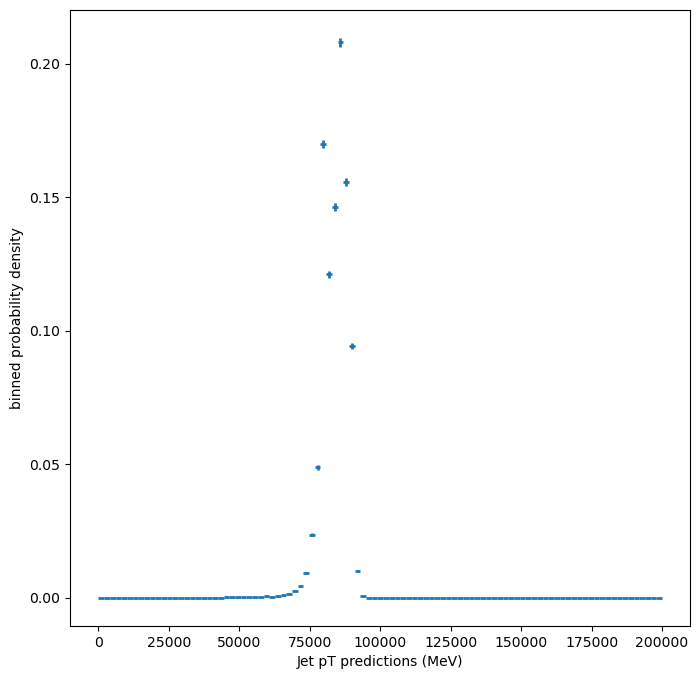

In [24]:
fig = binneddensity(pred[:,0], fixedbinning(0,200000, 100), xlabel = 'Jet pT predictions (MeV)')
fig

In [25]:
pTdiff = bhads[:,0] - pred[:,0]
pTerr = numpy.exp(pred[:,2])
pTpull = pTdiff / pTerr

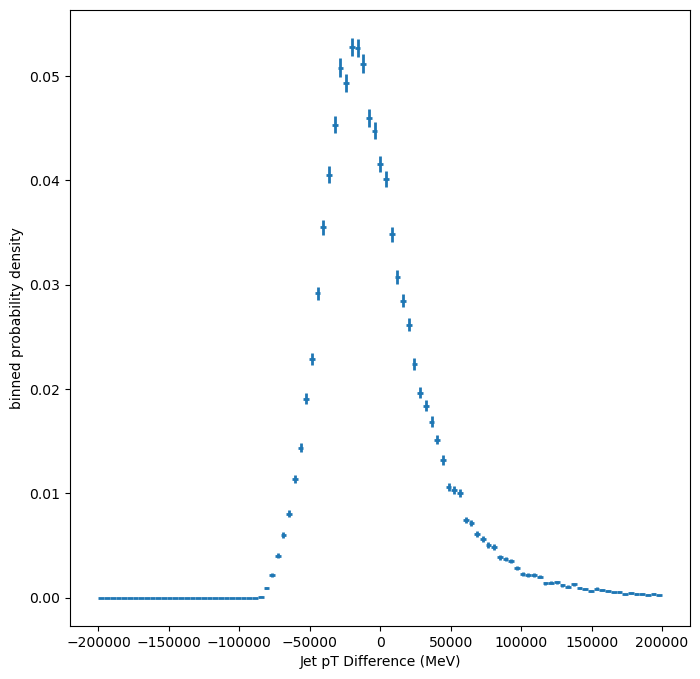

In [26]:
fig = binneddensity(pTdiff, fixedbinning(-200000,200000, 100), xlabel = 'Jet pT Difference (MeV)')
fig

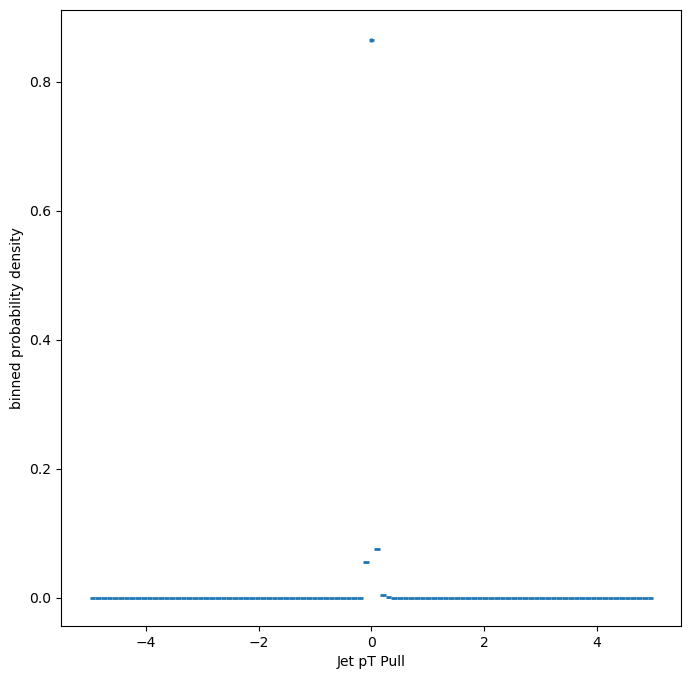

In [27]:
fig = binneddensity(pTpull, fixedbinning(-5,5,100), xlabel = 'Jet pT Pull')
fig